In [1]:
import os
import math
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm
from matplotlib import pyplot as plt
import requests
import zipfile
import subprocess
import gzip
import shutil
import json

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(message)s",
    level=logging.INFO
)

# Data Processing

In [3]:
# take Amazon Beauty as an example
DATASET = 'amazon_beauty' 
RAW_PATH = os.path.join('./', DATASET)

In [4]:
# download data if not exists
if not os.path.exists(RAW_PATH):
    subprocess.call('mkdir ' + RAW_PATH, shell=True)
if not os.path.exists(os.path.join(RAW_PATH, DATASET + '.zip')):
    logging.info('Downloading data into ' + RAW_PATH)
    subprocess.call(
        'cd {} && curl -O https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz'
        .format(RAW_PATH, DATASET), shell=True)
    logging.info('Unzip files...')
    with gzip.open(os.path.join(RAW_PATH, 'reviews_Beauty_5.json.gz'), 'rb') as f_in:
            with open(os.path.join(RAW_PATH, 'reviews_Beauty_5.json'), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    

Unzip files...


In [5]:
interactions = [] # user_id, item_id, rating, time
with open(os.path.join(RAW_PATH, 'reviews_Beauty_5.json')) as F:
    for line in tqdm(F):
        review = json.loads(line)
        info =[review['reviewerID'],review['asin'],review['overall'],review['unixReviewTime']]
        interactions.append(info)
pos_interactions = [info for info in interactions if info[-2]>=3]
logging.info("Positive interaction: %d"%(len(pos_interactions)))

198502it [00:01, 110722.66it/s]
Positive interaction: 176520


In [6]:
# 3-times filter, one time
cold_user, cold_item = 10,10
exclude_user, exclude_item = set(),set()
user_cnt, item_cnt = dict(),dict()
for inter in pos_interactions:
    user_cnt[inter[0]] = user_cnt.get(inter[0],0)+1
    item_cnt[inter[1]] = item_cnt.get(inter[1],0)+1
exclude_user = set([u for u in user_cnt if user_cnt[u]<3])
exclude_item = set([i for i in item_cnt if item_cnt[i]<3])
core_interactions = [info for info in pos_interactions if 
                     info[0] not in exclude_user and info[1] not in exclude_item]
logging.info("Core interactions: %d"%(len(core_interactions)))

Core interactions: 175646


In [7]:
# split dataset: leave-one-out
core_inter = pd.DataFrame(core_interactions, columns = ['user_name','item_name','rating','timestamp']).sort_values(by='timestamp')
user2id = dict(zip(sorted(core_inter.user_name.unique()), range(1,core_inter.user_name.nunique()+1)))
item2id = dict(zip(sorted(core_inter.item_name.unique()), range(1,core_inter.item_name.nunique()+1)))
core_inter['user_id'] = core_inter.user_name.apply(lambda x: user2id[x])
core_inter['item_id'] = core_inter.item_name.apply(lambda x: item2id[x])

user_cnt = core_inter.user_id.value_counts().reset_index()
user_cnt.columns = ['user_id','inter_num']
dev_users = user_cnt.loc[user_cnt.inter_num>2].user_id
test = core_inter.groupby('user_id').tail(1)
test = test.loc[test.user_id.isin(dev_users)]
dev = core_inter.groupby('user_id').tail(2).groupby('user_id').head(1)
dev = dev.loc[dev.user_id.isin(dev_users)]
testdev_idx = test.index.to_list() + dev.index.to_list()
train = core_inter[~core_inter.index.isin(testdev_idx)]
logging.info("Training set: %d, Validation set: %d, Test set: %d"%(train.shape[0],dev.shape[0],test.shape[0]))
logging.info("#User=%d, #Item=%d"%(core_inter.user_id.nunique(),core_inter.item_id.nunique()))

Training set: 131780, Validation set: 21933, Test set: 21933
#User=21934, #Item=12014


In [8]:
# save dataset
train.to_csv(os.path.join(RAW_PATH,'train.csv'),index=False)
dev.to_csv(os.path.join(RAW_PATH,'dev.csv'),index=False)
test.to_csv(os.path.join(RAW_PATH,'test.csv'),index=False)

# Recommender Implementation

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import gc

In [10]:
def batch_to_gpu(batch, device):
    for c in batch:
        if type(batch[c]) is torch.Tensor:
            batch[c] = batch[c].to(device)
    return batch

def _append_history_info(data_df):
    """
    user_his: store user history sequence [(i1,t1), (i1,t2), ...]
    add the 'position' of each interaction in user_his to data_df
    """
    logging.info('Appending history info...')
    all_df = pd.concat([data_df[key] for key in data_df])
    sort_df = all_df.sort_values(by=['timestamp', 'user_id'], kind='mergesort')
    position = list()
    user_his = dict()  # store the already seen sequence of each user
    for uid, iid, t in zip(sort_df['user_id'], sort_df['item_id'], sort_df['timestamp']):
        if uid not in user_his:
            user_his[uid] = list()
        position.append(len(user_his[uid]))
        user_his[uid].append((iid, t))
    sort_df['position'] = position
    for key in data_df:
        data_df[key] = pd.merge(left=data_df[key], right=sort_df, how='left',on=['user_id', 'item_id', 'timestamp'])
    return data_df, user_his

def check_dir(file_name: str):
    dir_path = os.path.dirname(file_name)
    if not os.path.exists(dir_path):
        print('make dirs:', dir_path)
        os.makedirs(dir_path)

def _build_optimizer(model,optimizer_name="Adam", learning_rate=0.001, l2=0):
    logging.info('Optimizer: ' + optimizer_name)
    optimizer = eval('torch.optim.{}'.format(optimizer_name))(
        model.customize_parameters(), lr=learning_rate, weight_decay=l2)
    return optimizer

In [11]:
# Here we show GRU4Rec as an example. It can be replaced by any existing recommender.
class GRU4Rec(nn.Module):
    @staticmethod
    def init_weights(m):
        if 'Linear' in str(type(m)):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean=0.0, std=0.01)
        elif 'Embedding' in str(type(m)):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            
    def __init__(self, n_items, emb_size=64, hidden_size=64,model_path = "",device=torch.device('cuda')):
        super().__init__()
        self.item_num = n_items
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.model_path = model_path
        if not len(self.model_path):
            self.model_path = "Default_model.pt"
        self.device = device
        self.optimizer = None
        self._define_params()
        self.apply(self.init_weights)

    def _define_params(self):
        self.i_embeddings = nn.Embedding(self.item_num, self.emb_size)
        self.rnn = nn.GRU(input_size=self.emb_size, hidden_size=self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.emb_size)

    def forward(self, feed_dict):
        i_ids = feed_dict['item_id']  # [batch_size, -1]
        history = feed_dict['history_items']  # [batch_size, history_max]
        lengths = feed_dict['lengths']  # [batch_size]
        his_vectors = self.i_embeddings(history)
        # Sort and Pack
        sort_his_lengths, sort_idx = torch.topk(lengths, k=len(lengths))
        sort_his_vectors = his_vectors.index_select(dim=0, index=sort_idx)
        history_packed = torch.nn.utils.rnn.pack_padded_sequence(
            sort_his_vectors, sort_his_lengths.cpu(), batch_first=True)
        # RNN
        output, hidden = self.rnn(history_packed, None)
        # Unsort
        unsort_idx = torch.topk(sort_idx, k=len(lengths), largest=False)[1]
        rnn_vector = hidden[-1].index_select(dim=0, index=unsort_idx)
        # Predicts
        pred_vectors = self.i_embeddings(i_ids)
        rnn_vector = self.out(rnn_vector)
        prediction = (rnn_vector[:, None, :] * pred_vectors).sum(-1)
        return {'prediction': prediction.view(feed_dict['batch_size'], -1)}
    
    def save_model(self, model_path=None):
        if model_path is None:
            model_path = self.model_path
        check_dir(model_path)
        torch.save(self.state_dict(), model_path)

    def load_model(self, model_path=None):
        if model_path is None:
            model_path = self.model_path
        self.load_state_dict(torch.load(model_path))
        logging.info('Load model from ' + model_path)

    def customize_parameters(self) -> list:
        # customize optimizer settings for different parameters
        weight_p, bias_p = [], []
        for name, p in filter(lambda x: x[1].requires_grad, self.named_parameters()):
            if 'bias' in name:
                bias_p.append(p)
            else:
                weight_p.append(p)
        optimize_dict = [{'params': weight_p}, {'params': bias_p, 'weight_decay': 0}]
        return optimize_dict

# Dataset Class
class RecDataset(Dataset):
    def __init__(self, data_df, n_items, test_all=True, user_his=dict(), phase='test', 
                 history_max=20, clicked_set=()):
        self.phase = phase  # train / dev / test
        self.n_items = n_items
        self.test_all = test_all # evaluate on the ranking of all items
        self.user_his = user_his
        self.history_max = history_max
        self.clicked_set = clicked_set
        self.data = data_df.to_dict('list')
        idx_select = np.array(self.data['position']) > 0  # history length must be non-zero
        for key in self.data:
            self.data[key] = np.array(self.data[key],dtype=object)[idx_select].tolist()
 
    def __len__(self):
        if type(self.data) == dict:
            for key in self.data:
                return len(self.data[key])
        return len(self.data)

    def __getitem__(self, index: int) -> dict:
        return self._get_feed_dict(index)

    # get a sample
    def _get_feed_dict(self, index: int) -> dict:
        user_id, target_item = self.data['user_id'][index], self.data['item_id'][index]
        if self.phase != 'train' and self.test_all:
            neg_items = np.arange(1, self.n_items) # test on all items
        else:
            neg_items = self.data['neg_items'][index]
        item_ids = np.concatenate([[target_item], neg_items]).astype(int)
        feed_dict = {'user_id': user_id,'item_id': item_ids}
        pos = self.data['position'][index]
        user_seq = self.user_his[feed_dict['user_id']][:pos]
        if self.history_max > 0:
            user_seq = user_seq[-self.history_max:]
        feed_dict['history_items'] = np.array([x[0] for x in user_seq])
        feed_dict['lengths'] = len(feed_dict['history_items'])
        return feed_dict

    def actions_before_epoch(self):
        # negative sampling for training
        neg_items = np.random.randint(1, self.n_items, size=(len(self), 1))
        for i, u in enumerate(self.data['user_id']):
            clicked_set = self.clicked_set[u]  # neg items are possible to appear in dev/test set
            while neg_items[i][0] in clicked_set:
                neg_items[i][0] = np.random.randint(1, self.n_items)
        self.data['neg_items'] = neg_items
    
    # Collate a batch according to the list of feed dicts
    def collate_batch(self, feed_dicts) -> dict:
        feed_dict = dict()
        for key in feed_dicts[0]:
            if isinstance(feed_dicts[0][key], np.ndarray):
                tmp_list = [len(d[key]) for d in feed_dicts]
                if any([tmp_list[0] != l for l in tmp_list]):
                    stack_val = np.array([d[key] for d in feed_dicts], dtype=np.object)
                else:
                    stack_val = np.array([d[key] for d in feed_dicts])
            else:
                stack_val = np.array([d[key] for d in feed_dicts])
            if stack_val.dtype == np.object:  # inconsistent length (e.g., history)
                feed_dict[key] = pad_sequence([torch.from_numpy(x) for x in stack_val], batch_first=True)
            else:
                feed_dict[key] = torch.from_numpy(stack_val)
        feed_dict['batch_size'] = len(feed_dicts)
        feed_dict['phase'] = self.phase
        return feed_dict

In [12]:
# define basic params for model training & evaluation
device = torch.device('cuda')
n_items = core_inter.item_id.max()+1
batch_size = 64
EPOCH = 100
EARLY_STOP = 10
MAIN_METRIC='HR@100'

In [13]:
# Model training & Evaluation functions
def BPR_loss(out_dict):
    predictions = out_dict['prediction']
    pos_pred, neg_pred = predictions[:, 0], predictions[:, 1:]
    neg_softmax = (neg_pred - neg_pred.max()).softmax(dim=1)
    loss = -(((pos_pred[:, None] - neg_pred).sigmoid() * neg_softmax).sum(dim=1)).clamp(min=1e-8,max=1-1e-8).log().mean()
    return loss

def rec_fit(Recommender, dataset, loss_fn, epoch):
    dataset.actions_before_epoch()  # must sample before multi thread start
    Recommender.train()
    if Recommender.optimizer is None:
        Recommender.optimizer = _build_optimizer(Recommender)
    loss_lst = list()
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=dataset.collate_batch)
    for batch in tqdm(dl, desc='Epoch {:<3}'.format(epoch), ncols=100, position=0,leave=True):
        batch = batch_to_gpu(batch, Recommender.device)
        Recommender.optimizer.zero_grad()
        out_dict = Recommender(batch)
        loss = loss_fn(out_dict)
        loss.backward()
        Recommender.optimizer.step()
        loss_lst.append(loss.detach().cpu().data.numpy())
    return np.mean(loss_lst).item()

def rec_evaluate(Recommender, dataset, metric):
    Recommender.eval()
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_batch)
    evaluations = list()
    for batch in tqdm(dl, desc='Predict',ncols=100, position=0,leave=True):
        predictions = Recommender(batch_to_gpu(batch, device))['prediction']
        predictions = predictions.cpu().data.numpy()
        # exclude interacted items
        rows, cols = list(), list()
        for i, u in enumerate(batch['user_id'].cpu().data.numpy()):
            clicked_items = list(clicked_set[u])
            idx = list(np.ones_like(clicked_items) * i)
            rows.extend(idx)
            cols.extend(clicked_items)
        predictions[rows, cols] = -np.inf
        if 'HR' in metric:
            topk = int(metric.split("@")[-1])
            evaluations.extend((predictions>predictions[:,:1]).sum(axis=-1)<topk)
        elif metric == 'ranking':
            evaluations.extend((predictions>predictions[:,:1]).sum(axis=-1))
    evaluations = np.array(evaluations)   
    return evaluations

In [14]:
# record all items the user has clicked
clicked_set = dict()
train_clicked_set = dict()
for phase, df in enumerate([train,dev,test]):
    for u,i in zip(df.user_id, df.item_id):
        clicked_set.setdefault(u, set()).add(i)
        if phase == 0:
            train_clicked_set.setdefault(u,set()).add(i)

# construct dataset
data_df = {'train':train,'dev':dev,'test':test}
# append history info
data_df, user_his = _append_history_info(data_df)

Appending history info...


In [15]:
# define model and dataset
Recommender = GRU4Rec(n_items = n_items, model_path = "./GRU4Rec.pt")
Recommender.to(device)
dataset_dict = dict()
for key in data_df:
    dataset_dict[key] = RecDataset(data_df[key], n_items, test_all=True, phase='dev',user_his=user_his,
                                  clicked_set=train_clicked_set)

In [16]:
# Start training!
main_metric_results = []
for epoch in range(EPOCH):
    gc.collect()
    torch.cuda.empty_cache()
    train_loss = rec_fit(Recommender, dataset_dict['train'], loss_fn=BPR_loss, epoch=epoch)
    dev_eval = rec_evaluate(Recommender, dataset_dict['dev'], MAIN_METRIC).mean()
    main_metric_results.append(dev_eval)
    logging_str = 'Epoch {:<5} loss={:<.4f}, dev {}=({:<.4f})'.format(epoch + 1, train_loss, MAIN_METRIC, dev_eval)
    if max(main_metric_results) == main_metric_results[-1]:
        Recommender.save_model()
        logging_str += ' *'
    logging.info(logging_str)
    if len(main_metric_results)-np.argmax(main_metric_results)>EARLY_STOP:
        break
Recommender.load_model()

# Get failure counts
rec_failure_cnts = rec_evaluate(Recommender, dataset_dict['test'], 'ranking')

Optimizer: Adam
Predict: 100%|███████████████████████████████████████████████████| 343/343 [00:03<00:00, 101.54it/s]
Epoch 1     loss=0.5637, dev HR@100=(0.1342) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 97.13it/s]
Epoch 2     loss=0.4802, dev HR@100=(0.2002) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 96.85it/s]
Epoch 3     loss=0.4381, dev HR@100=(0.2171) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 96.44it/s]
Epoch 4     loss=0.4077, dev HR@100=(0.2263) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 96.73it/s]
Epoch 5     loss=0.3816, dev HR@100=(0.2302) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 97.74it/s]
Epoch 6     loss=0.3564, dev HR@100=(0.2349) *
Predict: 100%|████████████████████████████████████████████████████| 343/343 [00:03<00:00, 95.38i

# Test intelligence

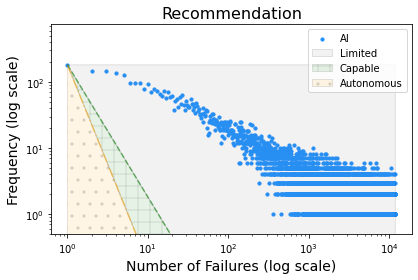

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans'

frequency = np.zeros(max(rec_failure_cnts) + 1)

for cnt in rec_failure_cnts:
    if cnt > 0 and cnt < len(frequency):
        frequency[cnt] += 1

plt.figure(figsize=(6, 4))

x = np.array(range(1, max(rec_failure_cnts) + 1))
# Plot histogram
plt.scatter(x, frequency[x], color="dodgerblue", s=10, label="AI")

y1 = (x.astype(np.float32))**-2 * frequency[1]
y2 = (x.astype(np.float32))**-3 * frequency[1]

# Draw two boundary lines # label=r'$y \propto x^{-2}$',# label=r'$y \propto x^{-3}$',
plt.plot(x, y1,  color='green', linestyle='--', alpha=0.5) 
plt.plot(x, y2,  color='orange', linestyle='-.', alpha=0.5) 

# Fill different regions between the curves
plt.fill_between(x, frequency[1], y1, color='gray', alpha=0.1, label="Limited", edgecolor="black")
plt.fill_between(x, y1, y2, color='green', alpha=0.1, hatch='+', label="Capable", edgecolor="black")
plt.fill_between(x, y2,0, color='orange', alpha=0.1, hatch='.', label="Autonomous", edgecolor="black")

# Set x-axis to log scale
plt.xscale('log')
# Set y-axis to log scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Failures (log scale)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.title(f'Recommendation', fontsize=16)

plt.tight_layout()

plt.legend(loc='upper right')

# set ylim lower bound to min(frequency)
plt.ylim(bottom=min(frequency[frequency > 0] / 2))

plt.show()